# Visualize computation of Musically Informed Metrics (MIMs)

In [1]:
import os
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for prototyping piano-roll visualizations
import pretty_midi as pm
import librosa
import librosa.display
import mir_eval
import mir_eval.display

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('..')

from eval.metrics.benchmarks import *
from eval.metrics.dynamics import *
from eval.metrics.harmony import *
from eval.metrics.articulation import *
from eval.metrics.timing import *

# from config import *
from helpers.analysis import *

# To avoid the following error when running mir_eval.display.piano_roll later:
# AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'
# I rolled back matplotlib to 3.7 as per https://github.com/librosa/librosa/issues/1763#issuecomment-1742120524

print(matplotlib.__version__)
assert matplotlib.__version__ == '3.7.0', 'mir_eval.display.piano_roll needs matplotlib @ 3.7.0'

/mnt/data/tmp/patricia/ipykernel_21915/3575195116.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


3.7.0


We will use the handcrafted example henceforth

In [2]:
ref_midi = '../data/poster_example/mozart_example_gt.mid'
pred_midi = '../data/poster_example/mozart_example_tr.mid'

ref_perf = pt.load_performance_midi(ref_midi)
pred_perf = pt.load_performance_midi(pred_midi)

Break it down: get internals of all metrics

In [3]:
### SHARED PREPROCESSING
assert 64 not in [c for c in pred_perf.performedparts[0].controls + ref_perf.performedparts[0].controls], \
    'sustain pedal use detected, reintroduce sustain_pedal_threshold and note_array recomputation in dynamics and articulation metrics'
ref_note_array = ref_perf.note_array()
pred_note_array = pred_perf.note_array()

### TIMING
melody, accompaniment = skyline_melody_identification_from_array(ref_note_array)
onsets_mel = np.unique(melody['onset_sec'])
onsets_acc = np.unique(accompaniment['onset_sec'])

ioi_melody_func = get_ioi_stream_func(melody)
ioi_accompaniment_func = get_ioi_stream_func(accompaniment)

melody_ioi_ref = ioi_melody_func(onsets_mel)
accompaniment_ioi_ref = ioi_accompaniment_func(onsets_acc)


melody_pred, accompaniment_pred = skyline_melody_identification_from_array(pred_note_array)

ioi_melody_pred_func = get_ioi_stream_func(melody_pred)
ioi_accompaniment_pred_func = get_ioi_stream_func(accompaniment_pred)

melody_ioi_pred = ioi_melody_pred_func(onsets_mel)
accompaniment_ioi_pred = ioi_accompaniment_pred_func(onsets_acc)

### ARTICULATION
kor_melody_ref_func, kor_bass_ref_func = get_kor_stream_funcs(ref_note_array)
ref_melody, ref_bass, ref_middle = skyline_melody_identification(note_array=ref_note_array)

onsets_arti = np.unique(ref_note_array["onset_sec"])

melody_kor_ref = kor_melody_ref_func(onsets_arti)
bass_kor_ref = kor_bass_ref_func(onsets_arti)

kor_melody_pred_func, kor_bass_pred_func = get_kor_stream_funcs(pred_note_array)
pred_melody, pred_bass, pred_middle = skyline_melody_identification(note_array=pred_note_array)

melody_kor_pred = kor_melody_pred_func(onsets_arti)
bass_kor_pred = kor_bass_pred_func(onsets_arti)

### DYNAMICS
dynamic_range_ref_func, _, _, ref_upper_voice, ref_lower_voice = get_upper_lower_stream_dynamic_range(note_array=ref_note_array, r_b=44.0)
dynamic_range_pred_func, _, _, pred_upper_voice, pred_lower_voice = get_upper_lower_stream_dynamic_range(note_array=pred_note_array, r_b=44.0)

onsets_dyn = ref_note_array["onset_sec"]

ref_dyn_rang = dynamic_range_ref_func(onsets_dyn)
pred_dyn_rang = dynamic_range_pred_func(onsets_dyn)

### HARMONY
ws = 5
ss = 1

onsets_harm, ref_cd, cd_func = get_tonal_tension_feature_func(
    ref_note_array, 'cloud_diameter', ws, ss, return_onsets=True)
ref_cm, cm_func = get_tonal_tension_feature_func(
    ref_note_array, 'cloud_momentum', ws, ss)

pred_cd, pred_cd_func = get_tonal_tension_feature_func(
    pred_note_array, 'cloud_diameter', ws, ss)
pred_cm, pred_cm_func = get_tonal_tension_feature_func(
    pred_note_array, 'cloud_momentum', ws, ss)
pred_cd = pred_cd_func(onsets_harm)
pred_cm = pred_cm_func(onsets_harm)

Plot

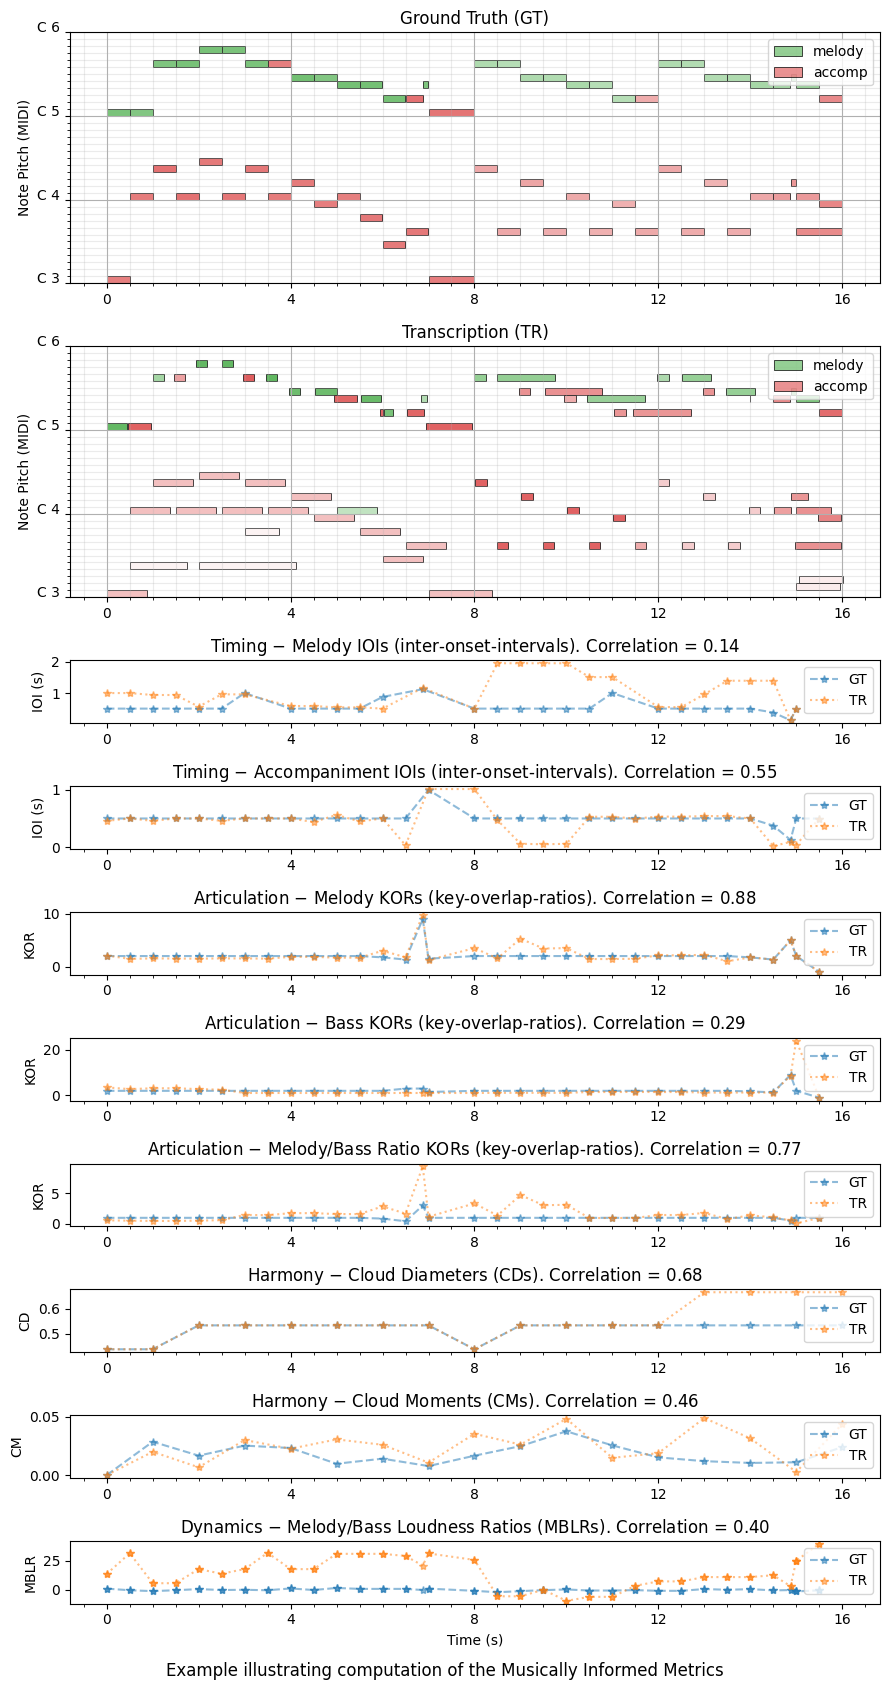

In [4]:
def get_rgba(color, alpha=0.5):
    import matplotlib.colors as mcolors
    return mcolors.to_rgb(color) + (alpha,)

def plot_everything_together(
        ### timing
        ref_melody, ref_accomp, pred_melody, pred_accomp,
        onsets_mel, melody_ioi_ref, melody_ioi_pred,
        onsets_acc, accomp_ioi_ref, accomp_ioi_pred,
        ### articulation
        onsets_arti, melody_kor_ref, melody_kor_pred, bass_kor_ref, bass_kor_pred,
        ### harmony
        onsets_harm, ref_cd, ref_cm, pred_cd, pred_cm,
        ### dymamics
        onsets_dyn, ref_dyn_rang, pred_dyn_rang,
        title='',
        ):
    '''Here comes the docstring. To Be Generated by GitHub Copilot.'''
    # plot the melody and accompaniment with separate colors, velocity as alpha
    fig, axs = plt.subplots(2+2+3+2+1, 1, figsize=(16-4 -3, 8+2+3+2+1 +1), sharex=True,
                            gridspec_kw={'height_ratios': [4,4, 1,1, 1,1,1, 1,1, 1]})

    lw = 0.5
    alpha = 0.5

    # ground truth
    ax = axs[0]

    mir_eval.display.piano_roll([], midi=[],
        label='melody', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
        
    mir_eval.display.piano_roll([], midi=[],
        label='accomp', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_accomp:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    # transcription
    ax = axs[1]

    mir_eval.display.piano_roll([], midi=[],
        label='melody', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    mir_eval.display.piano_roll([], midi=[],
        label='accomp', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_accomp:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))

    legend_loc = 'upper right'
    for ax in [axs[0], axs[1]]:
        ax.grid(True, which='major')
        ax.grid(True, which='minor', alpha=0.25)
        noterange=(pm.note_name_to_number('C3'), pm.note_name_to_number('C6'))
        ax.set_ybound(lower=noterange[0], upper=noterange[1])
        ax.legend(loc=legend_loc)

        mir_eval.display.ticker_notes(ax=ax) # replace midi pitch numbers with note names
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12.0)) # major tick each 12 semitones (1 octave)
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=4.0)) # major tick [seconds]
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.5)) # minor tick [seconds]
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.set_ylabel('Note Pitch (MIDI)');
        # ax.set_xlabel('Time (s)');
    
    axs[0].set_title('Ground Truth (GT)');
    axs[1].set_title('Transcription (TR)');

    metrics_label_ref = 'GT'
    metrics_label_pred = 'TR'

    # IOIs - timing
    melody_ioi_corr = np.corrcoef(melody_ioi_ref, melody_ioi_pred)[0, 1]
    accomp_ioi_corr = np.corrcoef(accomp_ioi_ref, accomp_ioi_pred)[0, 1]

    ax = axs[2]
    ax.plot(onsets_mel, melody_ioi_ref, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_mel, melody_ioi_pred, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('IOI (s)')
    ax.set_title(f'Timing $-$ Melody IOIs (inter-onset-intervals). Correlation = {melody_ioi_corr:.2f}')
    ax.legend(loc=legend_loc)
    
    ax = axs[3]
    ax.plot(onsets_acc, accomp_ioi_ref, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_acc, accomp_ioi_pred, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('IOI (s)')
    ax.set_title(f'Timing $-$ Accompaniment IOIs (inter-onset-intervals). Correlation = {accomp_ioi_corr:.2f}')
    ax.legend(loc=legend_loc)

    # KORs - articulation
    ratio_kor_ref = melody_kor_ref / bass_kor_ref
    ratio_kor_pred = melody_kor_pred / bass_kor_pred
    melody_kor_corr = np.corrcoef(melody_kor_ref, melody_kor_pred)[0, 1]
    bass_kor_corr = np.corrcoef(bass_kor_ref, bass_kor_pred)[0, 1]
    ratio_kor_corr = np.corrcoef(ratio_kor_ref, ratio_kor_pred)[0, 1]

    ax = axs[4]
    ax.plot(onsets_arti, melody_kor_ref, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_arti, melody_kor_pred, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('KOR')
    ax.set_title(f'Articulation $-$ Melody KORs (key-overlap-ratios). Correlation = {melody_kor_corr:.2f}')
    ax.legend(loc=legend_loc)

    ax = axs[5]
    ax.plot(onsets_arti, bass_kor_ref, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_arti, bass_kor_pred, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('KOR')
    ax.set_title(f'Articulation $-$ Bass KORs (key-overlap-ratios). Correlation = {bass_kor_corr:.2f}')
    ax.legend(loc=legend_loc)

    ax = axs[6]
    ax.plot(onsets_arti, ratio_kor_ref, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_arti, ratio_kor_pred, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('KOR')
    ax.set_title(f'Articulation $-$ Melody/Bass Ratio KORs (key-overlap-ratios). Correlation = {ratio_kor_corr:.2f}')
    ax.legend(loc=legend_loc)

    # CD/CM - harmony
    cd_corr = np.corrcoef(ref_cd, pred_cd)[0, 1]
    cm_corr = np.corrcoef(ref_cm, pred_cm)[0, 1]

    ax = axs[7]
    ax.plot(onsets_harm, ref_cd, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_harm, pred_cd, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('CD')
    ax.set_title(f'Harmony $-$ Cloud Diameters (CDs). Correlation = {cd_corr:.2f}')
    ax.legend(loc=legend_loc)

    ax = axs[8]
    ax.plot(onsets_harm, ref_cm, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_harm, pred_cm, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('CM')
    ax.set_title(f'Harmony $-$ Cloud Moments (CMs). Correlation = {cm_corr:.2f}')
    ax.legend(loc=legend_loc)

    # MBLR - dynamics
    dyn_corr = np.corrcoef(ref_dyn_rang, pred_dyn_rang)[0, 1]

    ax = axs[9]
    ax.plot(onsets_dyn, ref_dyn_rang, alpha=.5, linestyle='--', marker='*', label=metrics_label_ref)
    ax.plot(onsets_dyn, pred_dyn_rang, alpha=.5, linestyle=':', marker='*', label=metrics_label_pred)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('MBLR')
    ax.set_title(f'Dynamics $-$ Melody/Bass Loudness Ratios (MBLRs). Correlation = {dyn_corr:.2f}')
    ax.legend(loc=legend_loc)

    ax.set_xlabel('Time (s)');

    fig.suptitle(title, y=0.0)

    fig.tight_layout()
    
    return fig, axs

fig, axs = plot_everything_together(
    ### shared
    # ref_note_array, pred_note_array,
    ### timing
    melody, accompaniment, melody_pred, accompaniment_pred,
    onsets_mel, melody_ioi_ref, melody_ioi_pred,
    onsets_acc, accompaniment_ioi_ref, accompaniment_ioi_pred,
    ### articulation
    # ref_melody, ref_bass, ref_middle,
    # pred_melody, pred_bass, pred_middle,
    onsets_arti, melody_kor_ref, melody_kor_pred, bass_kor_ref, bass_kor_pred,
    ### harmony
    onsets_harm, ref_cd, ref_cm, pred_cd, pred_cm,
    ### dymamics
    # ref_upper_voice, ref_lower_voice,
    # pred_upper_voice, pred_lower_voice,
    onsets_dyn, ref_dyn_rang, pred_dyn_rang,
    title='Example illustrating computation of the Musically Informed Metrics'
)
fig.savefig('../poster/poster_fig5_zusammen.pdf', bbox_inches='tight')